In [1]:
import time

from scipy.stats import linregress
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler

# import Gaussian process
from parabola.gp import *

# update plot parameters
params = {'legend.fontsize': 12,
          'figure.figsize': (12, 9),
          'lines.linewidth':4,
         'axes.labelsize': 20,
         'axes.titlesize':24,
          'axes.linewidth':2,
         'xtick.labelsize':22,
         'ytick.labelsize':22}
plt.rcParams.update(params)
plt.rcParams['pdf.fonttype'] = 42

np.random.seed(123)

In [2]:
# COSINES
def f(x):
    x, y = x
    u = 1.6*x - .5
    v = 1.6*y - .5
    return 1 - (u**2 + v**2 - .3*np.cos(3*np.pi*u) - .3*np.cos(3*np.pi*v))

# ROSENBROCK
# def f(x):
#     x, y = x
#     return 10 - 100*(y - x**2)**2 - (1-x)**2

def generate_data(X, noise=0.):
    Nsamples = X.shape[0]
    Y = np.zeros([Nsamples, 1])
    
    for i in range(Nsamples):
        # add some standard Gaussian noise to Y
        Y[i] = f(X[i]) + noise*np.random.randn()

    return Y

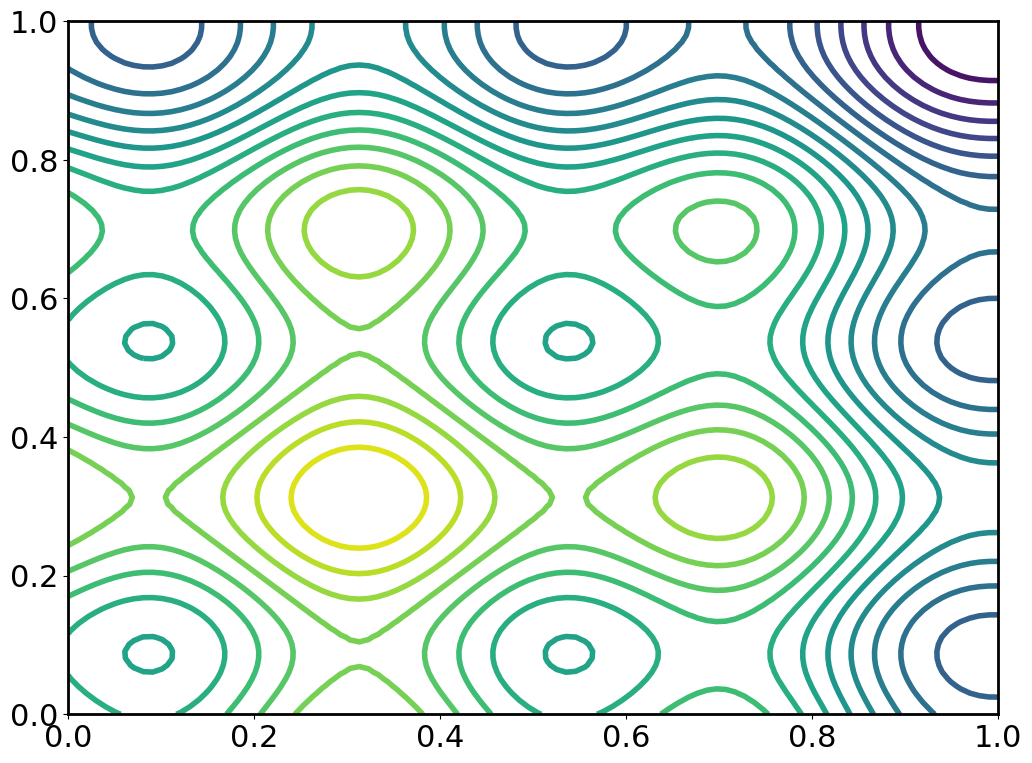

In [3]:
# define design space
n_grid = 100
F_grid = np.zeros([n_grid, n_grid])
X = np.linspace(0, 1, n_grid)
Y = np.linspace(0, 1, n_grid)
Xmesh,Ymesh = np.meshgrid(X,Y)

# test datapoints
X_design = np.stack([Xmesh.ravel(), Ymesh.ravel()]).T
Y_design = generate_data(X_design)

for i, xi in enumerate(X):
    for j, yj in enumerate(Y):
        F_grid[j,i] = f([xi,yj])
        
plt.contour(Xmesh, Ymesh, F_grid, levels=np.linspace(np.min(F_grid), np.max(F_grid), n_grid//5))   
plt.show()

In [4]:
# define number of test points
n_init = 10
n_test = 5
n_cycles = 10
noise = .05
beta  = 1. / noise**2 # precision = inverse variance of noise 

# train data points
X_train = np.random.uniform(size=[n_init, 2])
Y_train = generate_data(X_train, noise=noise)

Max replicates exceeded, switching to pure exploration


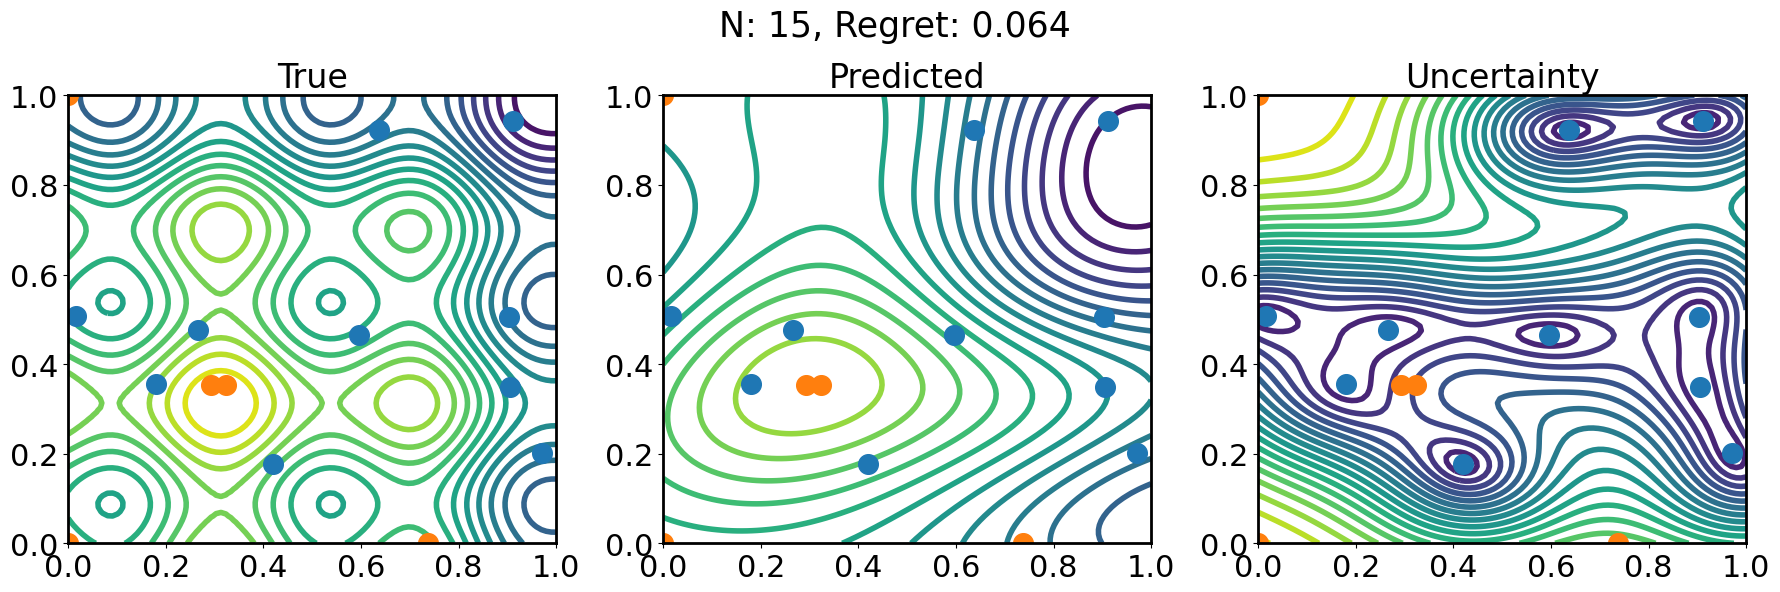

Max replicates exceeded, switching to pure exploration


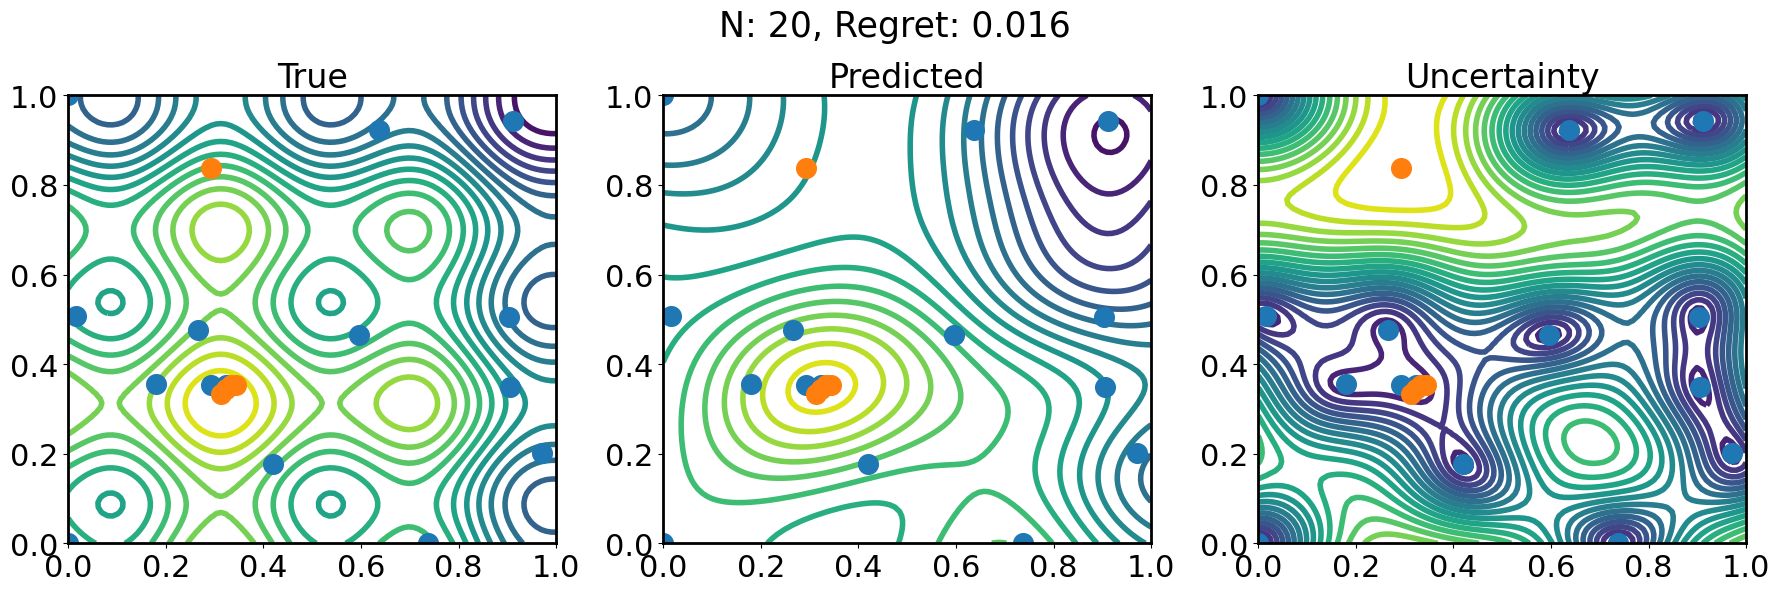

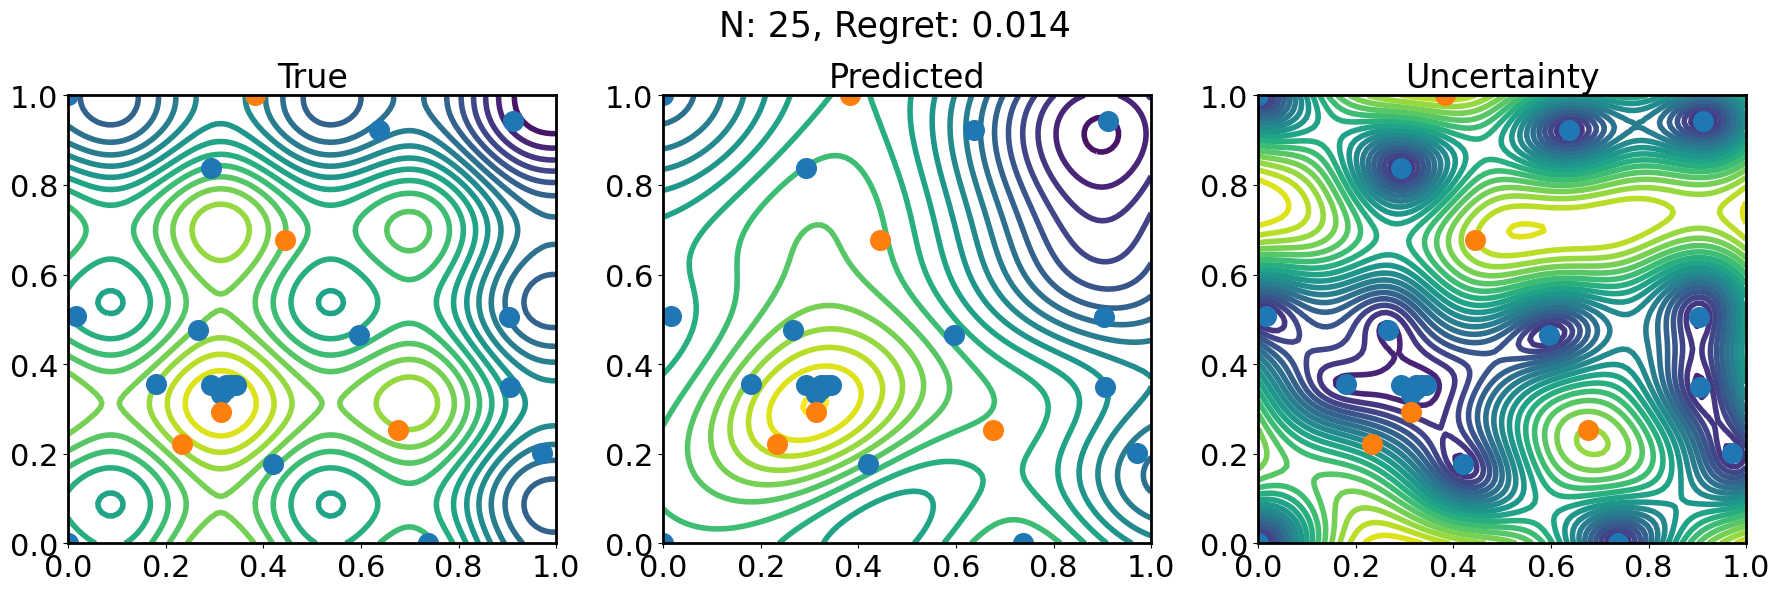

Max replicates exceeded, switching to pure exploration


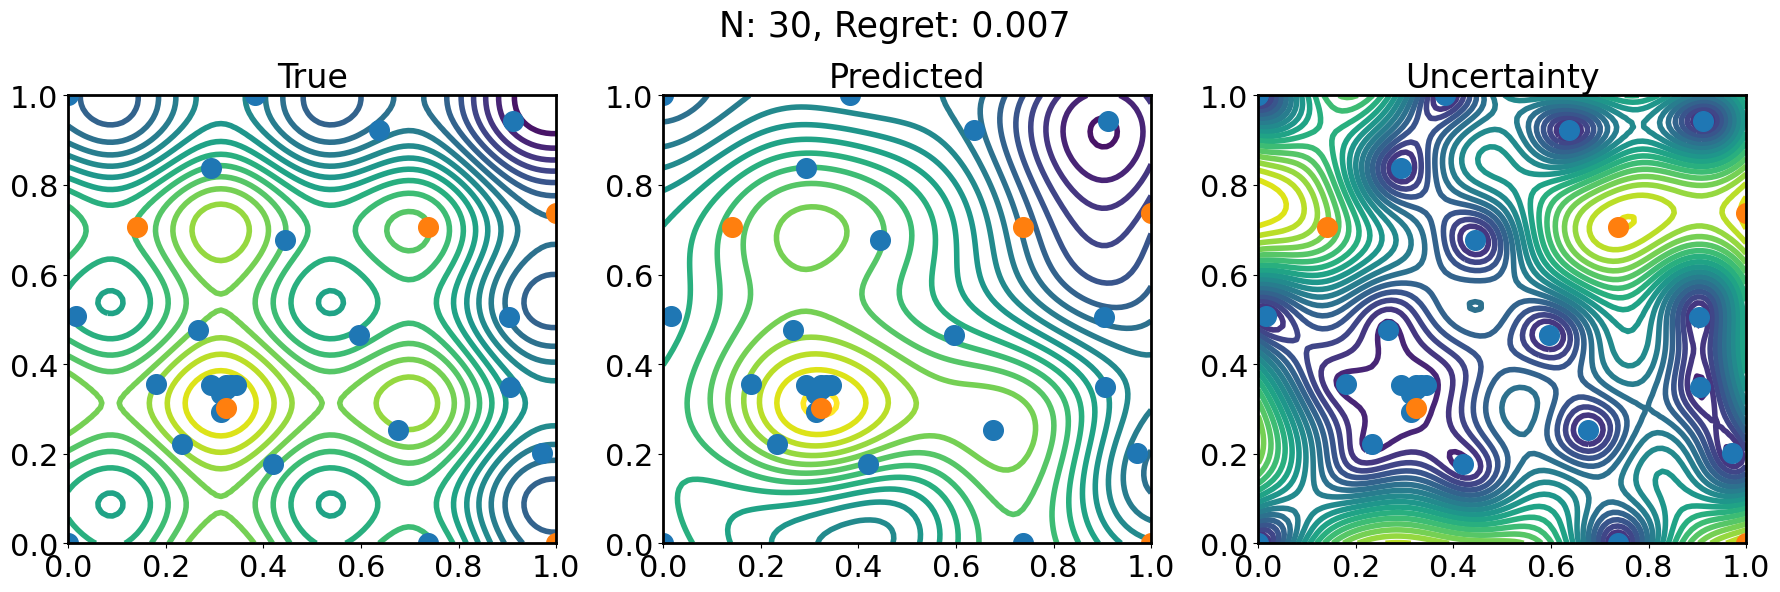

Max replicates exceeded, switching to pure exploration


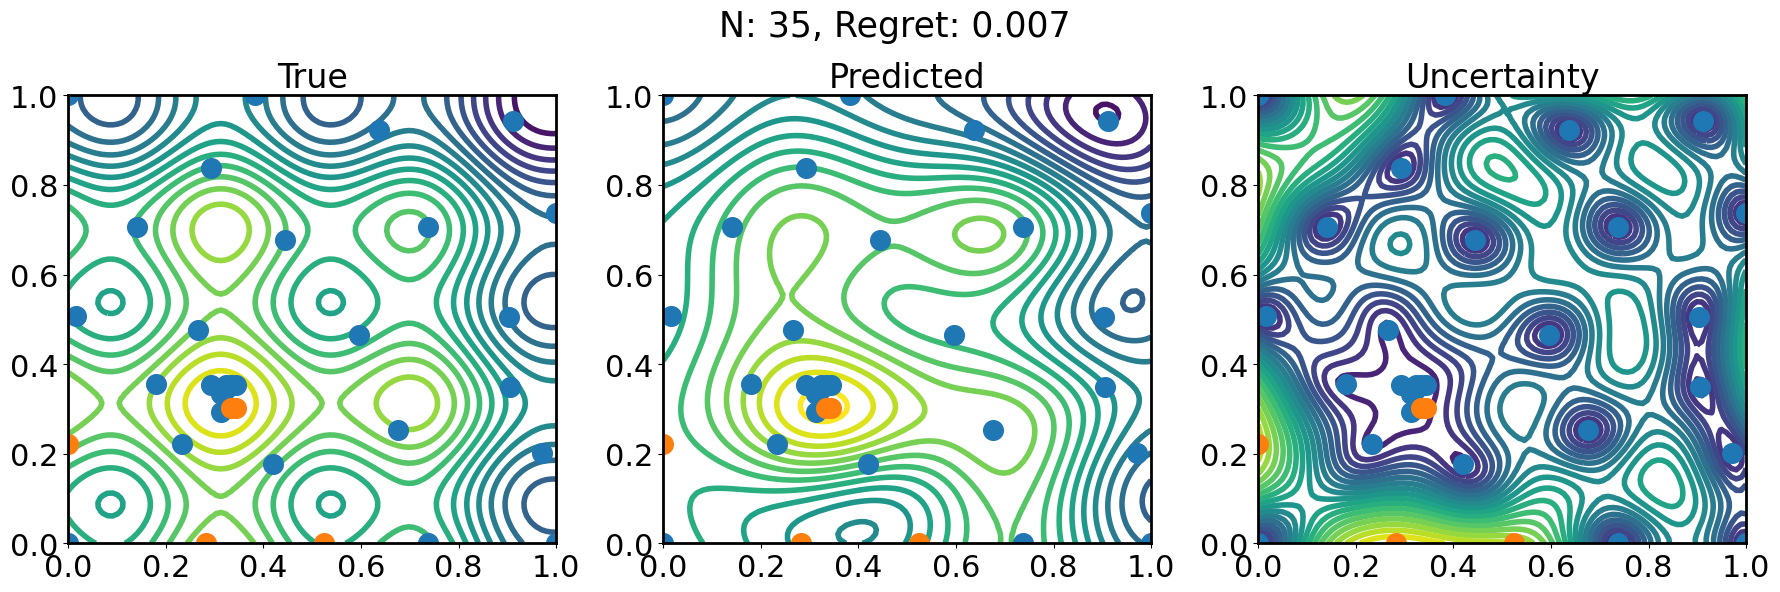

Max replicates exceeded, switching to pure exploration


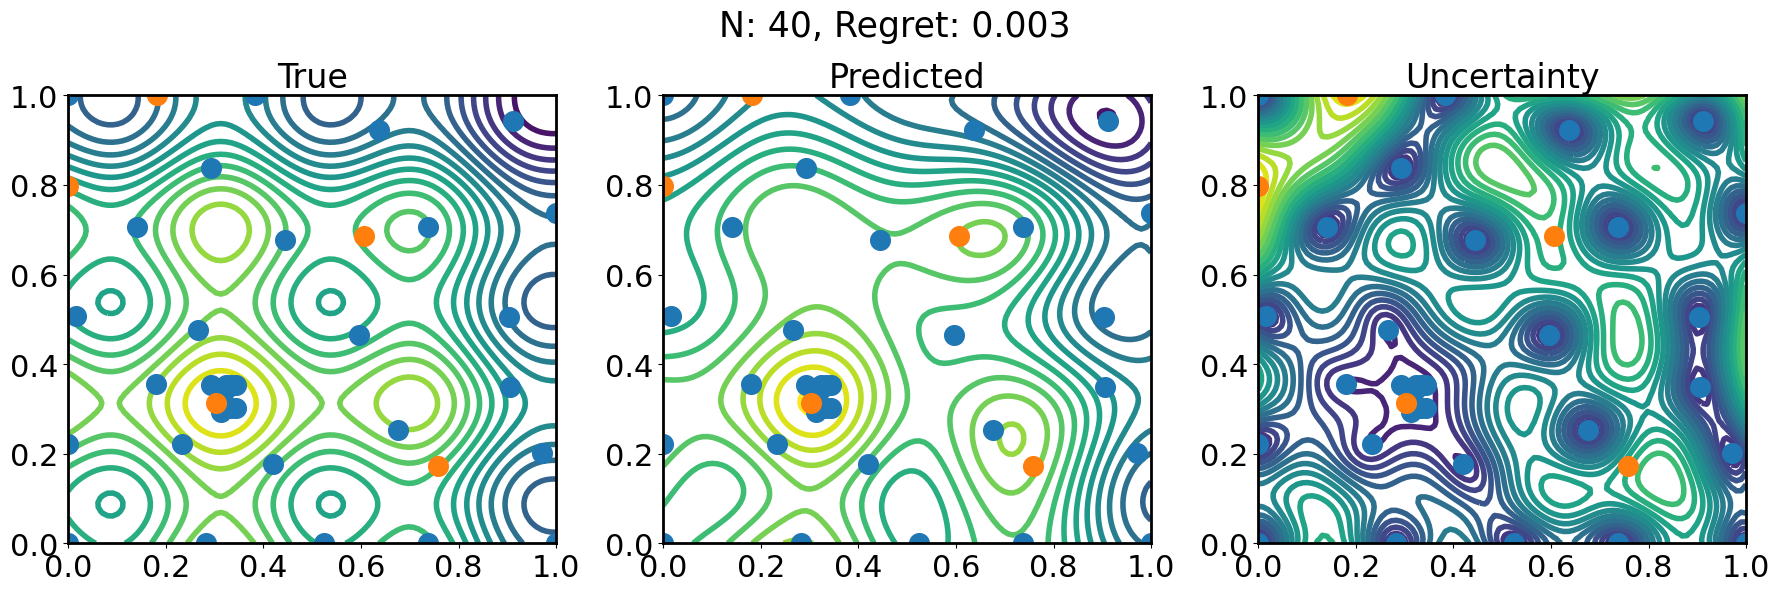

Max replicates exceeded, switching to pure exploration


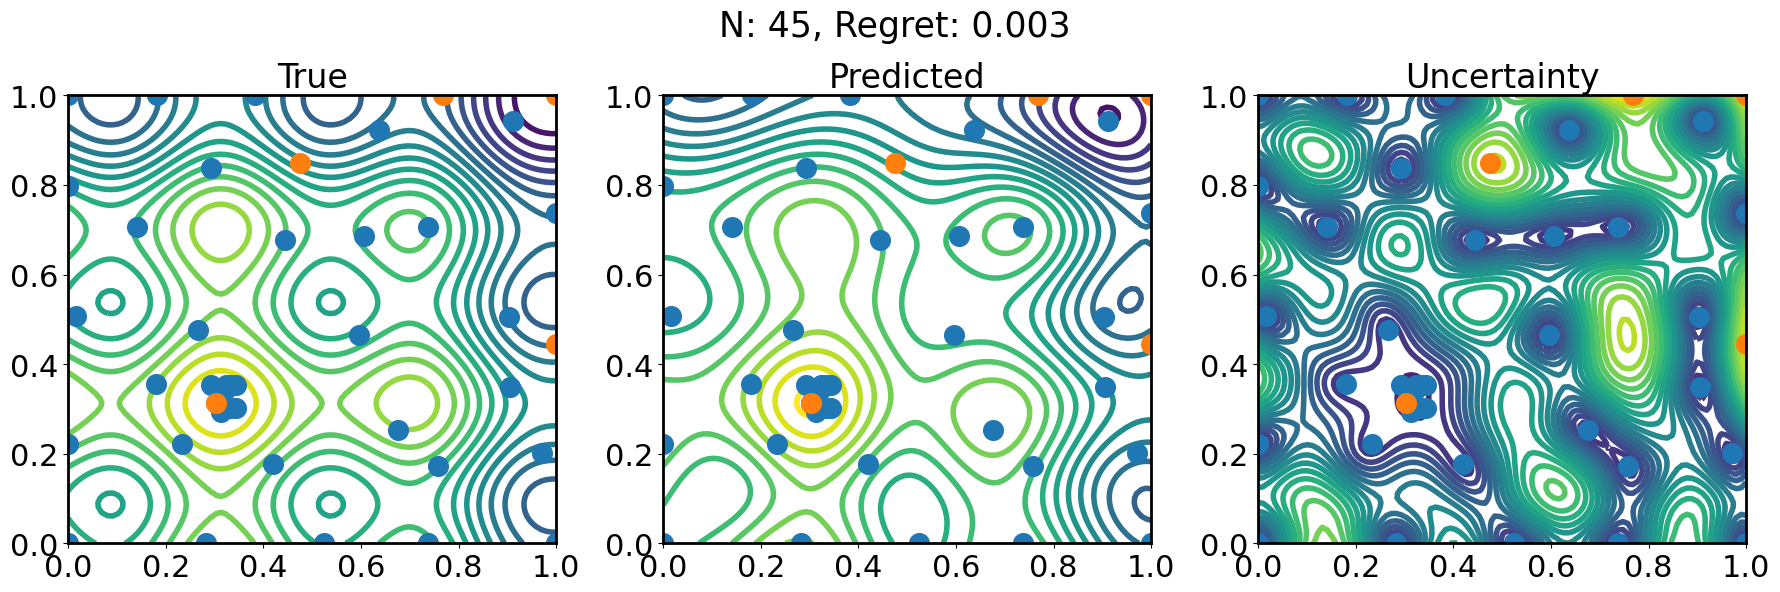

Max replicates exceeded, switching to pure exploration


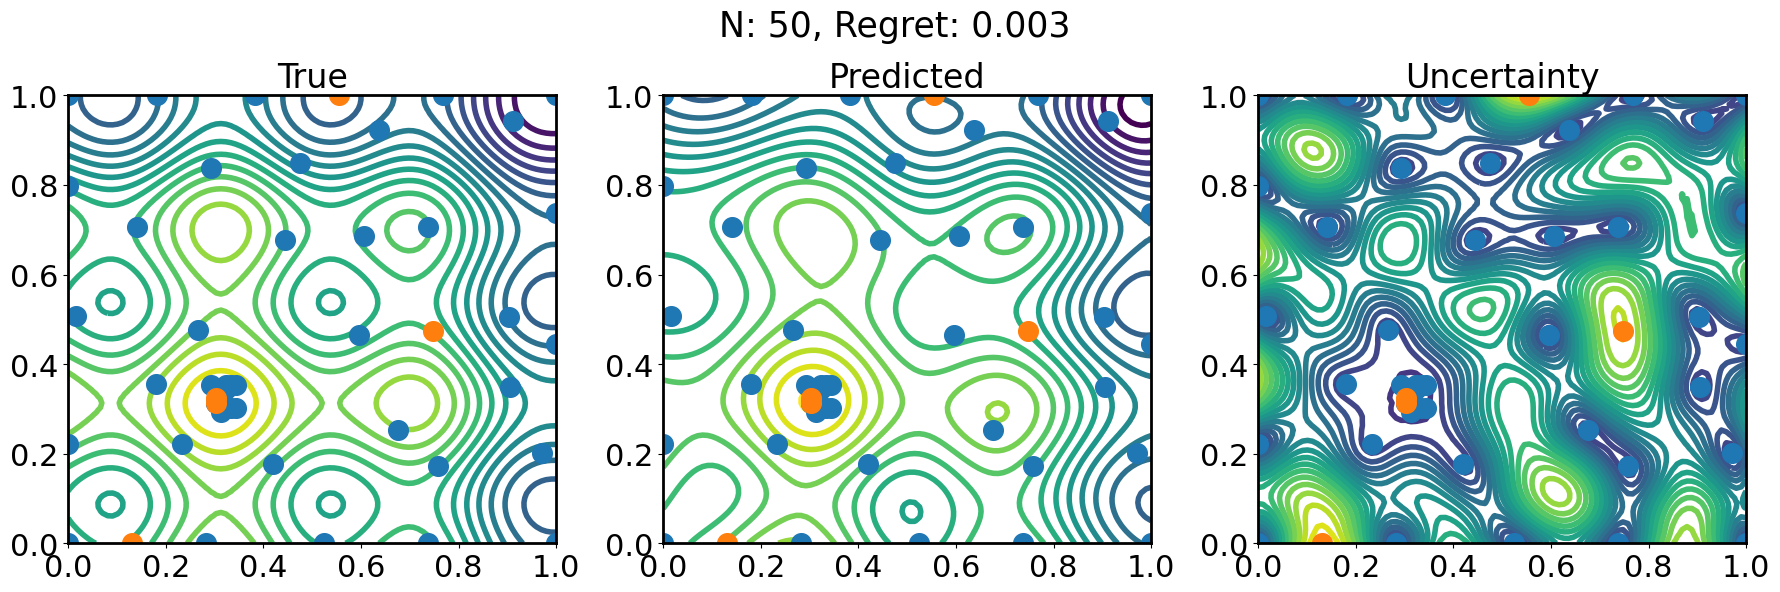

Max replicates exceeded, switching to pure exploration


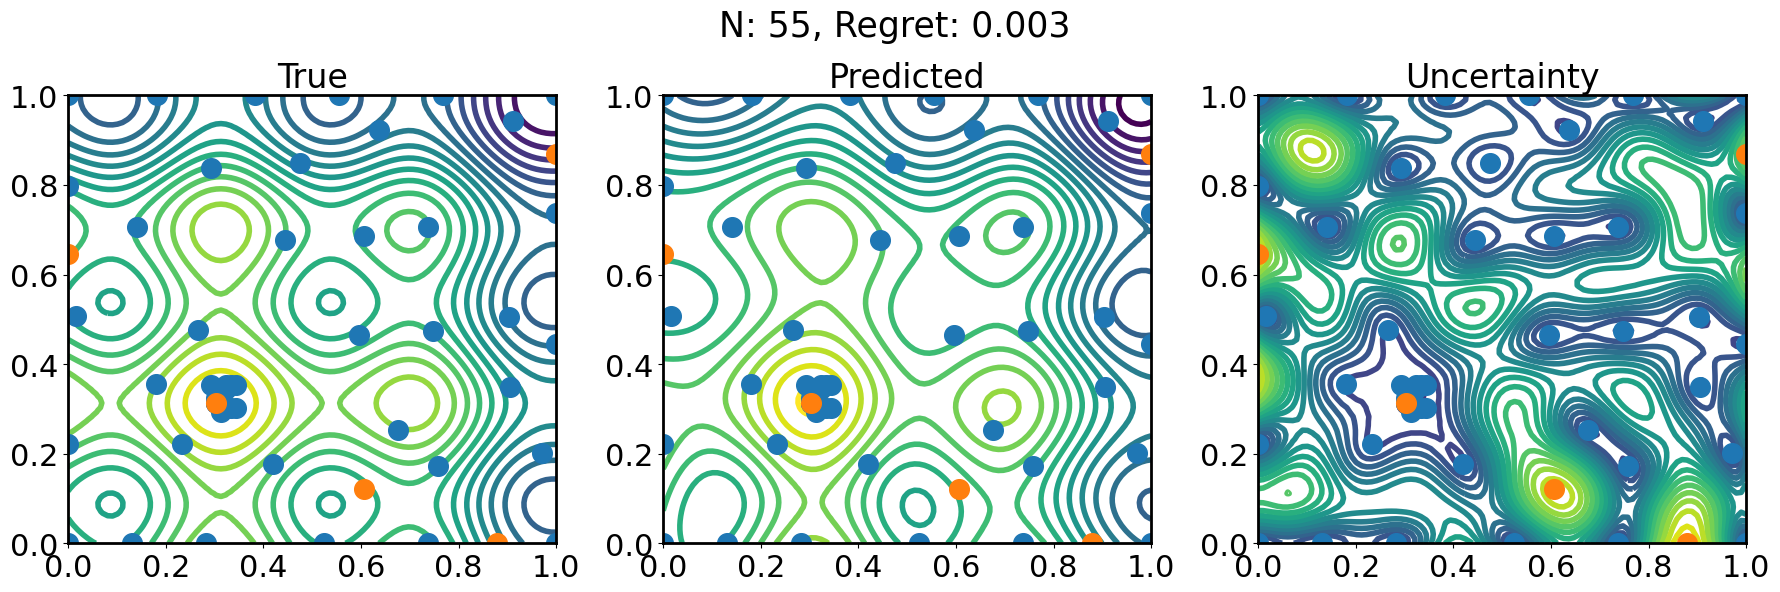

Max replicates exceeded, switching to pure exploration


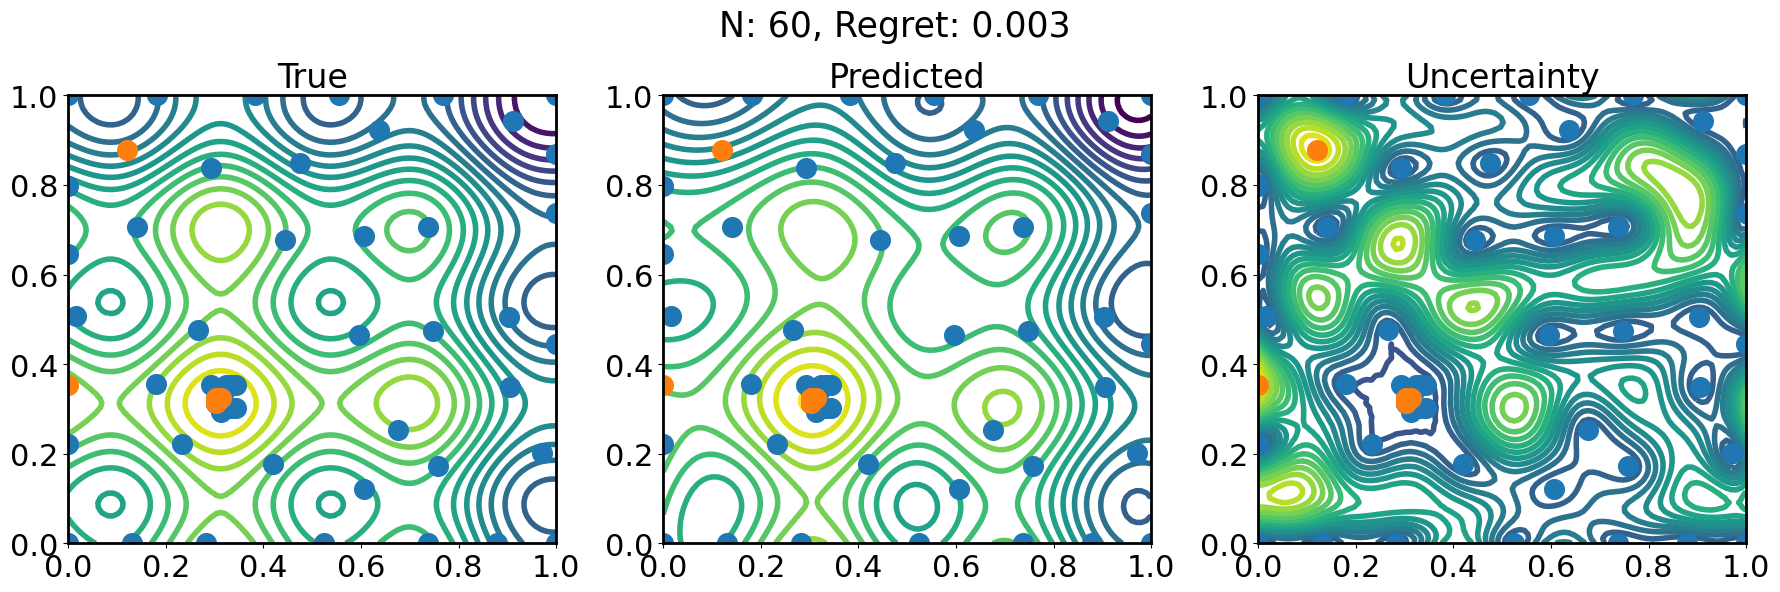

In [5]:
stdv_levels = np.exp(.15*np.linspace(0, 20, n_grid//5)) -1 

# life
regret = np.inf

# BO over cycles
for i in range(n_cycles):
    # scale data
    Xscaler = StandardScaler().fit(X_train)
    X_train = Xscaler.transform(X_train)
    X_test  = Xscaler.transform(X_design)

    Yscaler = StandardScaler().fit(np.vstack(Y_train))
    Y_train = Yscaler.transform(np.vstack(Y_train))
    Y_test  = Yscaler.transform(np.vstack(Y_design))

    n_inputs = X_train.shape[1]
    n_outputs = Y_train.shape[1]

    # init Gaussian process
    gp = GP(kernel, [1], beta)

    # fit to training data 
    gp.fit(X_train, Y_train)
    
    # Design next experiment

    # Expected improvement objective
    fstar = np.max(Y_train)
    def objective(pred, stdv):
        improvement = pred - fstar
        Z = improvement/stdv
        return improvement*cdf(Z) + stdv*pdf(Z)

    design_inds = gp.search(X_test, objective, n_test)
    X_old = Xscaler.inverse_transform(X_train) 
    Y_old = Yscaler.inverse_transform(Y_train)
    X_new = X_design[design_inds]
    Y_new = Y_design[design_inds]

    # plot model approximation of objective and uncertainty
    Y, Y_stdv = gp.predict(X_test)

    F_pred = np.reshape(Yscaler.inverse_transform(np.vstack(Y)), [n_grid, n_grid])
    F_stdv = np.reshape(Yscaler.scale_*Y_stdv, [n_grid, n_grid])
    Y_min = np.min(Y_design)
    Y_max = np.max(Y_design)

    plt.figure(figsize=(18, 6))
    plt.subplot(131)
    plt.contour(Xmesh, Ymesh, F_grid, levels=np.linspace(Y_min, Y_max, n_grid//5), zorder=0)  
    plt.scatter(X_old[:,0], X_old[:,1], s=200, zorder=1)
    plt.scatter(X_new[:,0], X_new[:,1], s=200, zorder=2)
    plt.title("True")

    plt.subplot(132)
    plt.contour(Xmesh, Ymesh, F_pred, levels=np.linspace(Y_min, Y_max, n_grid//5), zorder=0)
    plt.scatter(X_old[:,0], X_old[:,1], s=200, zorder=1)
    plt.scatter(X_new[:,0], X_new[:,1], s=200, zorder=2)
    plt.title("Predicted")

    plt.subplot(133)
    # plt.contour(Xmesh, Ymesh, F_stdv, levels=stdv_levels, zorder=0)
    plt.contour(Xmesh, Ymesh, F_stdv, levels=np.linspace(0., np.max(F_stdv), n_grid//5), zorder=0)
    plt.scatter(X_old[:,0], X_old[:,1], s=200, zorder=1)
    plt.scatter(X_new[:,0], X_new[:,1], s=200, zorder=2)
    plt.title("Uncertainty")

    # compute regret
    regret = min([regret, np.max(Y_design) - np.max(Y_new)])
    plt.suptitle("N: {:.0f}, Regret: {:.3f}".format(X_train.shape[0]+X_new.shape[0], regret), fontsize=25)
    plt.tight_layout()
    plt.show()

    # update training data with new design
    
    # sample several replicates of response
    Y_new = generate_data(X_new, noise=noise)
    
    '''# matrix to average over replicate samples
    unique_designs, counts = np.unique(design_inds, return_counts=True)
    C = np.zeros([len(unique_designs), len(design_inds)])
    k = 0
    for i,c in enumerate(counts):
        C[i,k:k+c] = 1.
        k += c

    # average over replicates
    X_new = np.einsum('nm,mk,n->nk', C, X_new, 1./counts) 
    Y_new = np.einsum('nm,mk,n->nk', C, Y_new, 1./counts)'''
    
    # update training data with new data 
    X_train = np.concatenate((X_old, X_new))
    Y_train = np.concatenate((Y_old, Y_new))